# Lab10_A5 – Dimensionality Reduction

## Exercice 5: Stochastic Neighbour Embedding on MNIST dataset

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### (a) Using t-SNE to reduce the dimensionality to two dimensions

*Exercise: Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.*

In [2]:
from sklearn.decomposition import PCA

Let's start by loading the MNIST dataset:

In [3]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [4]:
np.random.seed(42)

m = 5000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset (This can take quite a while...):

In [5]:
from sklearn.manifold import TSNE

tsne = ...
X_reduced = tsne.fit_transform(...)

AttributeError: 'ellipsis' object has no attribute 'fit_transform'

Now let's use Matplotlib's `scatter()` function to plot a scatterplot, using a different color for each digit:

In [6]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

NameError: name 'X_reduced' is not defined

<Figure size 936x720 with 0 Axes>

Isn't this just beautiful? :) This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

### (b) Labelling the Clusters

Let's focus on digits 2, 3 and 5, which seem to overlap a lot.

In [7]:
plt.figure(figsize=(9,9))
cmap = matplotlib.cm.get_cmap("jet")
for digit in (2, 3, 5):
    color=np.array(cmap(digit / 9)).reshape(1,4)
    plt.scatter(X_reduced[y == digit, 0],...., c=color)
plt.axis('off')
plt.show()

SyntaxError: invalid syntax (<ipython-input-7-e9040ce900c5>, line 5)

### t-SNE instead of PCA

Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [8]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(..., random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

TypeError: '>' not supported between instances of 'ellipsis' and 'int'

In [9]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    color=np.array(cmap(digit / 9)).reshape(1,4)
    plt.scatter(X_subset_reduced[y_subset == digit, 0], ..., c=color)
plt.axis('off')
plt.show()

NameError: name 'cmap' is not defined

<Figure size 648x648 with 0 Axes>

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now. 

*Exercise: Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.*

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples ([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digit dataset).

In [10]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        color=np.array(cmap(digit / 9)).reshape(1,4)
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=color)
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's just write colored digits:

In [11]:
plot_digits(X_reduced, y)

NameError: name 'X_reduced' is not defined

Well that's okay, but not that beautiful. Let's try with the digit images:

In [12]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

NameError: name 'X_reduced' is not defined

In [13]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

NameError: name 'X_subset_reduced' is not defined

*Exercise: Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.*

Let's start with PCA. We will also time how long it takes:

PCA took 0.2s.


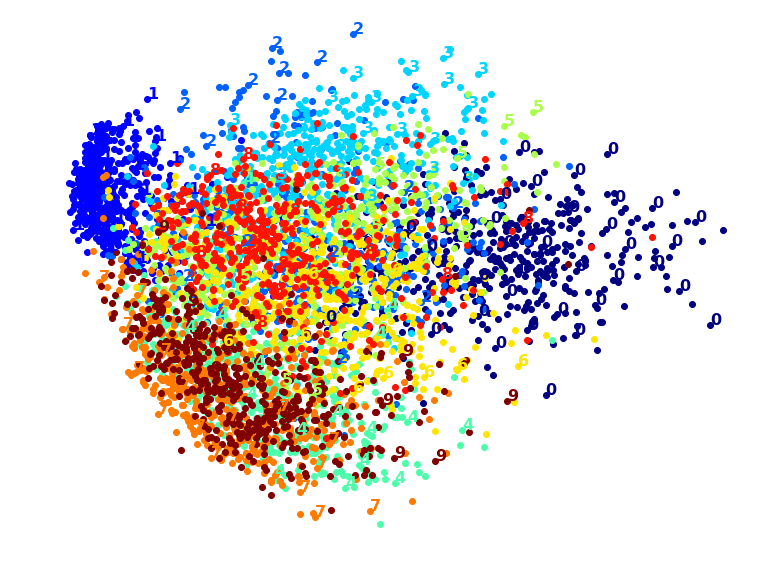

In [22]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

### (c) Using other dimensionality reduction algorithms such as LLE, MDS and t-SNE

*First we start with LLE, i.e. Local Linear Embedding which is part of the mainfold class of sklearn.*

In [15]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(...., random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

SyntaxError: invalid syntax (<ipython-input-15-bb9ea5a940d5>, line 4)

That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

In [16]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=..., random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=..., random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

NameError: name 'LocallyLinearEmbedding' is not defined

The result is more or less the same, but this time it was almost 4× faster.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

In [17]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(...)
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, ....)
plt.show()

SyntaxError: invalid syntax (<ipython-input-17-0b13caecc286>, line 8)

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

In [18]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=..., random_state=42)),
    ("mds", MDS(n_components=..., random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

NameError: name 'MDS' is not defined

Same result, and no speedup: PCA did not help (or hurt).

Let's try LDA:

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(...).fit_transform(...)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

TypeError: fit() missing 1 required positional argument: 'y'

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:

In [20]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(...)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

t-SNE took 0.0s.


TypeError: float() argument must be a string or a number, not 'TSNE'

It's twice slower than LLE, but still much faster than MDS, and the result looks great. Let's see if a bit of PCA can speed it up:

PCA+t-SNE took 51.8s.


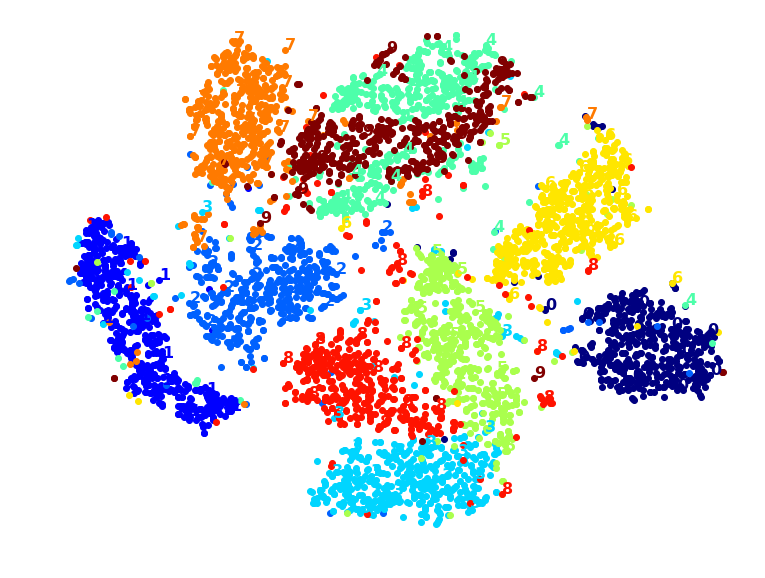

In [21]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Yes, PCA roughly gave us a 25% speedup, without damaging the result. We have a winner!